## **Análise dos métodos de detecção de Data drift da biblioteca Deepchecks**

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns1

from scipy import stats, special

### **Feature Drift**

#### **Característica alvo: "Nenhum"**

In [5]:
enade_treino = pd.read_csv("../../concept_drift/tabela_final_2017_tres_anos_treinamento.csv")
print(enade_treino["Numero_Participantes"].mean())
print(len(enade_treino["Numero_Participantes"]))

0.8299523144726316
1604


In [6]:
enade_teste = pd.read_csv("../../concept_drift/tabela_final_2021_tres_anos_treinamento.csv")
print(enade_teste["Numero_Participantes"].mean())
print(len(enade_teste["Numero_Participantes"]))

0.7655293865243439
1505


### **ECDF** (Empirical Cumulative Distribution Function)

An empirical distribution function is the function associated with the empirical measure of a sample. This cumulative distribution function is a step function that jumps up by 1/n at each of the n data points. Its value at any **specified value** of the measured variable is **the fraction of observations** of the measured variable that are **less than or equal to the specified value**.

No contexto do Enade, temos que o ECDF apresenta a fração $\mathcal{Y}$ de cursos de computação que apresentam uma porcentagem menor ou igual a $\mathcal{X}$ de alunos que escolheram a alternativa "Nenhum" para uma determinada questão.

Pergunta: Se não tivéssemos feito a transformação dos valores para porcentagens, estaria tudo certo? Ou transformar para porcentagens foi necessário? A normalização faria mesma coisa? Como a normalização faz parte do Pipeline de treinamento do modelo e não da formação do conjunto em si, talvez a transformação como operação canônica para formação do conjunto tem seu valor?

In [7]:
atributo = "Não sei responder.26"

In [8]:
# Create a sorted series of unique data (from the measured variable "Nenhum")
# The unique operation is done for the sake of the evenly spaced sequence operation below
# The sorting is for the probability calculation of each x_values in the loop
data_points = np.sort(enade_treino[atributo].unique())

# X-data for the ECDF: evenly spaced sequence of the uniques
# By doing this (evenly spaced sequence), the graph is smooth until the end
# Step function (for the evenly spaced sequence): (stop - start)/(num - 1)
x_values = np.linspace(start=min(data_points), stop=max(data_points),num=len(data_points))

In [9]:
# Total number of observations
data_size_treino = enade_treino[atributo].size

# Y-data for the ECDF:
y_values_treino = []

for i in x_values:
    # All the values in raw data less than the ith value in x_values
    temp = enade_treino[atributo][enade_treino[atributo] <= i]
    
    # Fraction of that range of values with respect to the total number of observations
    value = temp.size / data_size_treino
    
    # Pushing the fraction (cumulative probability of the ith value in x_values) in the y_values
    y_values_treino.append(value)

In [10]:
# Total number of observations
data_size_teste = enade_teste[atributo].size

# Y-data for the ECDF:
y_values_teste = []

for i in x_values:
    # All the values in raw data less than the ith value in x_values
    temp = enade_teste[atributo][enade_teste[atributo] <= i]
    
    # Fraction of that range of values with respect to the total number of observations
    value = temp.size / data_size_teste
    
    # Pushing the fraction (cumulative probability of the ith value in x_values) in the y_values
    y_values_teste.append(value)

In [11]:
# Calculate the K-S test metric for two CDF 'teste' e 'treino' on the measured variable "Nenhum"

differences = []
maxx = 0

for i in range(0, len(x_values)):
    diff = y_values_teste[i] - y_values_treino[i]
    differences
    
    if diff < 0:
        diff = diff * -1
   
    if diff > maxx:
        maxx = diff

print(maxx)

0.28659704559200005


In [ ]:
quantile = stats.quantile_test(y_values_treino)
ci = quantile.confidence_interval(confidence_level=0.95)
ci

<Axes: ylabel='Frequency'>

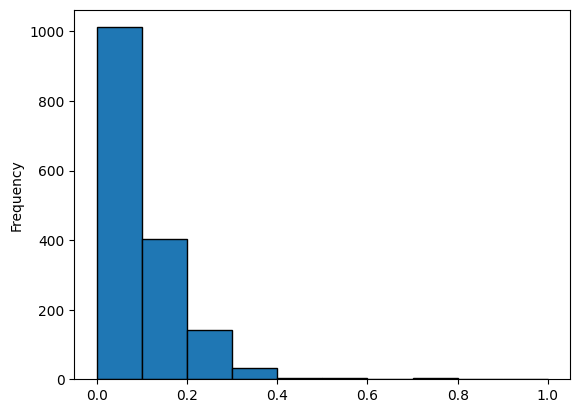

In [12]:
enade_treino[atributo].plot(kind='hist', edgecolor='black')

<Axes: ylabel='Frequency'>

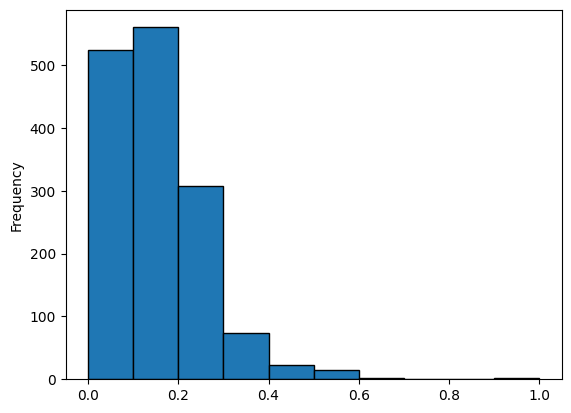

In [13]:
enade_teste[atributo].plot(kind='hist', edgecolor='black')

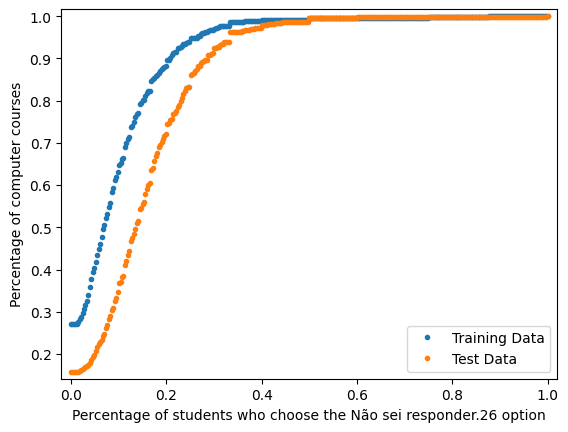

In [14]:
fig, ax = plt.subplots()

ax.plot(x_values, y_values_treino, marker='.', linestyle='none', label='Training Data')
ax.plot(x_values, y_values_teste, marker='.', linestyle='none', label='Test Data')

ax.set_xlabel(f"Percentage of students who choose the {atributo} option")
ax.set_ylabel("Percentage of computer courses")
ax.legend()
ax.margins(0.02)

plt.show()

#### **K-S Test usando a função da biblioteca Scipy**

In [2]:
enade_treino = pd.read_csv("../../concept_drift/tabela_final_2011_treinamento.csv")

enade_teste = pd.read_csv("../../concept_drift/tabela_final_2014_treinamento.csv")

In [3]:
column_names = enade_treino.columns

In [54]:
len(column_names)

169

In [7]:
drifted_columns_drift_score = {}
drifted_columns_pvalue = {}

for index in range(enade_treino.shape[1] - 1):
    valores_treino = enade_treino.iloc[:, index]
    valores_teste = enade_teste.iloc[:, index]
    
    result = stats.ks_2samp(valores_treino, valores_teste)
    
    if result.pvalue < 0.05:
        drifted_columns_drift_score[column_names[index]] = result.statistic
        drifted_columns_pvalue[column_names[index]] = result.pvalue

In [8]:
len(drifted_columns_drift_score)

97

In [9]:
len(drifted_columns_pvalue)

97

In [10]:
sorted_drift_score_results = sorted(drifted_columns_drift_score.items(), key=lambda column:column[1])
sorted_pvalue_results = sorted(drifted_columns_pvalue.items(), key=lambda column:column[1])

In [17]:
print(sorted_drift_score_results[-10:])

[('Não sei responder.3', 0.6254079418849334), ('Não sei responder.2', 0.6328707907629234), ('Não sei responder.4', 0.6329686641908314), ('nulos_Formacao', 0.6451827242524917), ('nulos_Disponibilidade_Professores', 0.6458471760797342), ('nulos_Dominio_Professores', 0.6458471760797342), ('nulos_Plano_de_Ensino', 0.6458471760797342), ('nulos_Condicao_Salas', 0.6465116279069767), ('nulos_Condicao_Praticas', 0.6465116279069767), ('Não sei responder.1', 0.6482510562174095)]


In [18]:
print(sorted_pvalue_results[:10])

[('Não sei responder.1', 6.958016489389675e-268), ('nulos_Condicao_Salas', 2.568697356544673e-266), ('nulos_Condicao_Praticas', 2.568697356544673e-266), ('nulos_Disponibilidade_Professores', 1.0202950000916362e-265), ('nulos_Dominio_Professores', 1.0202950000916362e-265), ('nulos_Plano_de_Ensino', 1.0202950000916362e-265), ('nulos_Formacao', 4.044415716150564e-265), ('Não sei responder.4', 2.8081480628893463e-254), ('Não sei responder.2', 3.439277291542687e-254), ('Não sei responder.3', 1.0314399714117015e-247)]


In [1]:
import math

In [16]:
# Primeiro temos D = 0.29
# Depois temos D' = 0.290 / math.sqrt(776)
# Depois temos Sd(D') = 1 - Fd(D'), onde Fd é a CDF da distrib. K-S
# E finalmente P-value = 1 - Sd(D') ou P-value = Sd(D * sqrt(N))

m = len(enade_treino)
n = len(enade_teste)

scaling_factor_n = float(m * n) / (m + n)

for item in sorted_drift_score_results[-10:]:
    drift_score = item[1]
    print(drift_score * math.sqrt(scaling_factor_n))
    print(stats.kstwo.sf(drift_score, np.round(scaling_factor_n)))

16.241445378040602
2.9684654463803557e-255
16.43525080374584
3.2462057186202305e-262
16.43779251424689
2.6252468483344983e-262
16.75498386416432
5.281209006451598e-274
16.772239254343685
1.1898180172339645e-274
16.772239254343685
1.1898180172339645e-274
16.772239254343685
1.1898180172339645e-274
16.78949464452305
2.673487649375826e-275
16.78949464452305
2.673487649375826e-275
16.834666488372307
5.29908104587869e-277


In [1]:
import numpy as np
from scipy.stats import kstwo
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2

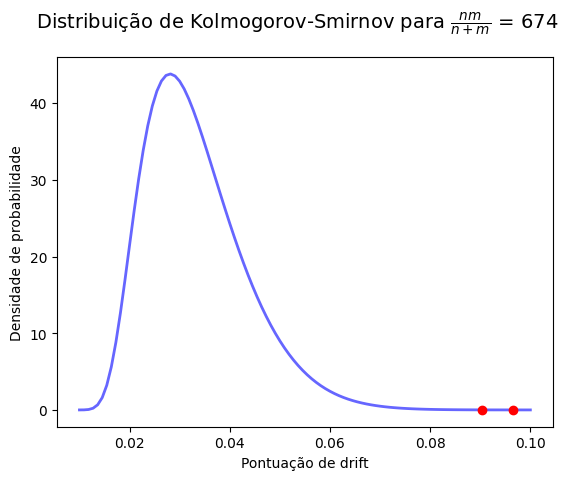

In [7]:
fig1, ax1 = plt1.subplots(1, 1)
n = 674
x = np.linspace(0.01, 0.1, 100)
ax1.plot(x, stats.kstwo.pdf(x, n), 'b-', lw=2, alpha=0.6, label='kstwo pdf')
#plt1.plot(0.0608,stats.kstwo.pdf(0.0608, n),color="red", marker='o')
plt1.plot(0.0965,stats.kstwo.pdf(0.0965, n), color="red", marker='o')
plt1.plot(0.0904,stats.kstwo.pdf(0.0904, n), color="red", marker='o')

ax1.set_xlabel("Pontuação de drift")
ax1.set_ylabel("Densidade de probabilidade")
fig1.suptitle(r'Distribuição de Kolmogorov-Smirnov para $\frac{nm}{n+m}$ = 674', fontsize=14)

plt1.savefig("distr_ks_674.png")
plt1.show()

In [8]:
# p-value
print(stats.kstwo.sf(0.0608, n))
print(stats.kstwo.sf(0.0965, n))
print(stats.kstwo.sf(0.0904, n))

0.013128726994314084
6.4836667232091375e-06
3.0439130481352446e-05


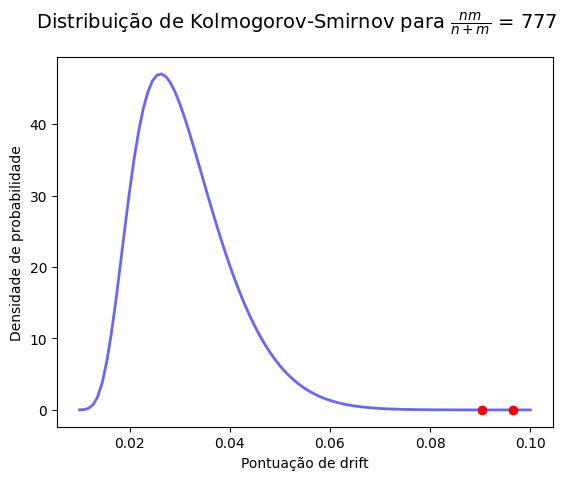

In [53]:
fig2, ax2 = plt2.subplots(1, 1)
n2 = 777
x = np.linspace(0.01, 0.1, 100)
ax2.plot(x, stats.kstwo.pdf(x, n2), 'b-', lw=2, alpha=0.6, label='kstwo pdf')
plt2.plot(0.0965,stats.kstwo.pdf(0.0965, n2), color="red", marker='o')
plt2.plot(0.0904,stats.kstwo.pdf(0.0904, n2), color="red", marker='o')

ax2.set_xlabel("Pontuação de drift")
ax2.set_ylabel("Densidade de probabilidade")
fig2.suptitle(r'Distribuição de Kolmogorov-Smirnov para $\frac{nm}{n+m}$ = 777', fontsize=14)

plt2.savefig("distr_ks_777.png")
plt2.show()

In [41]:
# p-value
print(stats.kstwo.sf(0.0965, n2))
print(stats.kstwo.sf(0.0904, n2))

9.483530414602629e-07
5.636097671021081e-06
